In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import ast
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import ctc_batch_cost
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [ ]:
from google.colab import userdata

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    file.write(userdata.get('kaggle'))

In [ ]:
!kaggle datasets download -d robikscube/textocr-text-extraction-from-images-dataset

Dataset URL: https://www.kaggle.com/datasets/robikscube/textocr-text-extraction-from-images-dataset
License(s): CC0-1.0
100% 6.72G/6.73G [01:27<00:00, 69.6MB/s]
100% 6.73G/6.73G [01:27<00:00, 82.7MB/s]


In [ ]:
with zipfile.ZipFile('/content/textocr-text-extraction-from-images-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [ ]:
!rm /content/textocr-text-extraction-from-images-dataset.zip

In [ ]:
annotations_file = '/content/dataset/annot.csv'
images_dir = '/content/dataset/train_val_images/train_images'

In [ ]:
annots = pd.read_csv(annotations_file)
annots.head()

,Unnamed: 0,id,image_id,bbox,utf8_string,points,area
0,0,a4ea732cd3d5948a_1,a4ea732cd3d5948a,"[525.83, 3.4, 197.64, 33.94]",Performance,"[525.83, 3.4, 723.47, 7.29, 722.76, 36.99, 525...",6707.90
1,1,a4ea732cd3d5948a_2,a4ea732cd3d5948a,"[534.67, 64.68, 91.22, 38.19]",Sport,"[535.73, 64.68, 623.41, 67.51, 625.89, 102.87,...",3483.69
2,2,a4ea732cd3d5948a_3,a4ea732cd3d5948a,"[626.95, 63.62, 96.52, 31.82]",Watch,"[626.95, 63.62, 721.7, 63.62, 723.47, 95.44, 6...",3071.27
3,3,a4ea732cd3d5948a_4,a4ea732cd3d5948a,"[577.4, 141.87, 147.13, 43.1]",...period.,"[580.02, 143.61, 724.53, 141.87, 723.66, 184.9...",6341.30
4,4,a4ea732cd3d5948a_5,a4ea732cd3d5948a,"[391.03, 163.9, 60.82, 38.65]",.,"[395.2, 163.9, 451.85, 191.94, 445.59, 202.55,...",2350.69


In [ ]:
img_loc = images_dir+'/'+annots['image_id'][0]+'.jpg'
img = cv2.imread(img_loc)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

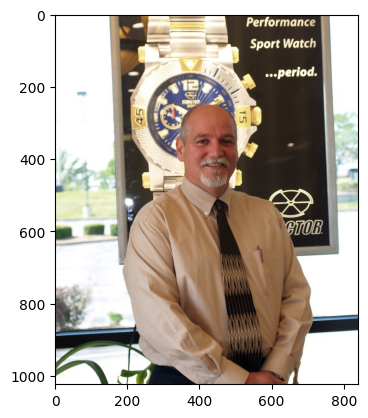

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
x,y,w,h = map(int,ast.literal_eval(annots['bbox'][0]))
print(x,y,w,h)

525 3 197 33


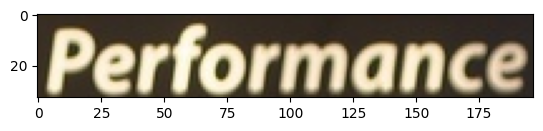

Performance


In [ ]:
plt.imshow(img[y:y+h,x:x+w,:])
plt.show();

print(annots['utf8_string'][0])

In [ ]:
def preprocess_image(img):
    if img.size == 0:
          raise ValueError("Empty image encountered during preprocessing.")

    image = cv2.resize(img, (128, 32))
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=-1)

    return image

In [ ]:
def one_hot_encode_sequences(sequences, num_classes):
    return [to_categorical(seq, num_classes=num_classes) for seq in sequences]

In [ ]:
def text_to_sequence(text, char_to_index):
    return [char_to_index.get(char, unk_index) for char in text]

In [ ]:
def padded_sequences(sequences, maxlen, num_classes):
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post', value=unk_index)
    return one_hot_encode_sequences(padded, num_classes)

In [ ]:
characters = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789."

# Create the mapping
char_to_index = {char: idx for idx, char in enumerate(characters)}

# Optionally, add a special token for unknown characters
unk_index = len(characters)
char_to_index['UNK'] = unk_index

# Create reverse mapping
index_to_char = {idx: char for char, idx in char_to_index.items()}

In [ ]:
def initialize_model(input_shape, num_classes):
    input_img = layers.Input(shape=input_shape, name='image_input')

    # Convolutional Layers
    x = layers.Conv2D(8, (3, 3), padding='same', activation='relu')(input_img)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)

    # Reshape for RNN
    new_shape = (input_shape[0] // 4, -1)  # Adjust this based on the lightweight architecture
    x = layers.Reshape(target_shape=new_shape)(x)

    # Recurrent Layers
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)

    # Fully connected layer
    x = layers.Dense(num_classes, activation='softmax')(x)

    # Model
    model = models.Model(inputs=input_img, outputs=x)

    model.summary()
    return model

In [ ]:
def ctc_loss_function(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
    input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
    label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

    loss = ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
input_shape = (32, 128, 1)
max_text_length = 8
num_classes =len(characters)+1

In [ ]:
model = initialize_model(input_shape, num_classes)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 32, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 128, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 128, 8)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 128, 16)         │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 64, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 64, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 32, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 32, 32)           │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 32, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 32, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 32, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 16, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 16, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 16, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 16, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 16, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 347,328 (1.32 MB)

 Trainable params: 346,976 (1.32 MB)

 Non-trainable params: 352 (1.38 KB)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
X, y = [], []
max_images = 100000
count = 0

for idx, row in tqdm(annots.iterrows()):
    if count >= max_images:
        break
    image_path = os.path.join(images_dir, f"{row['image_id']}.jpg")

    # Read and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Extract and process the bounding box
    x, y_, w, h = map(int, ast.literal_eval(row['bbox']))
    image = image[y_:y_+h, x:x+w]

    if image.size == 0:  # Additional check to ensure the cropped image is not empty
        print(f"Warning: Cropped image from {row['image_id']} is empty after bounding box application.")
        continue

    try:
        image = preprocess_image(image)
    except ValueError as e:
        print(e)
        continue  # Skip if preprocessing fails

    # Convert text to sequence and pad
    text = row['utf8_string']
    if isinstance(text,float):
        continue
    if len(text) > max_text_length:
        text = text[:max_text_length]
    text_sequence = text_to_sequence(text, char_to_index)
    text_sequence = padded_sequences([text_sequence], maxlen=max_text_length, num_classes=num_classes)
    text_sequence = np.squeeze(text_sequence, axis=0)

    # print(text)
    # print(text_sequence.shape)


    X.append(image)
    y.append(text_sequence)

    count += 1

6162it [01:09, 107.48it/s]

80028it [13:39, 114.25it/s]

93981it [15:59, 149.95it/s]

100005it [16:56, 98.36it/s]


In [ ]:
X,y = np.array(X),np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 70s 26ms/step - accuracy: 0.6530 - loss: 1.6726 - val_accuracy: 0.6679 - val_loss: 1.4630
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 92s 35ms/step - accuracy: 0.6748 - loss: 1.4221 - val_accuracy: 0.6823 - val_loss: 1.4894
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 63s 25ms/step - accuracy: 0.6951 - loss: 1.2979 - val_accuracy: 0.6980 - val_loss: 1.2704
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 95s 31ms/step - accuracy: 0.7104 - loss: 1.2089 - val_accuracy: 0.7116 - val_loss: 1.2013
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 71s 26ms/step - accuracy: 0.7269 - loss: 1.1245 - val_accuracy: 0.7212 - val_loss: 1.1712
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 86s 28ms/step - accuracy: 0.7374 - loss: 1.0733 - val_accuracy: 0.7328 - val_loss: 1.1258
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 83s 28ms/step - accuracy: 0.7460 - loss: 1.0228 - val_accuracy: 0.7374 - val_loss: 1.0892
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 76s 26ms/step - accuracy: 0.7538 -

In [ ]:
model.evaluate(X_test, y_test)

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7492 - loss: 1.0311


[1.0386558771133423, 0.7474625110626221]